# Data Preparation

In [8]:
## Load TEDS-D 2017 Data into a Pandas Data Frame
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

## Specify WD
#wd = "/home/abf/BINF667013_Final_Project/"
wd = (
    "/Users/adam/Documents/BINF667013_BigDataAnalyticsHealthcare/" +
    "Final_Project/TEDS_Study"
)
os.chdir(wd)

teds=pd.read_csv("datasets/tedsd_puf_2017.csv")
teds

## Convert '-9' to NA
teds=teds.replace({-9:np.nan})

### Count the number of complete cases in this dataset

In [9]:
teds.dropna().shape

(292, 76)

### Count the number of cases with valid observations for at least 50% of available measures

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 39, axis=1)
teds[mask].shape

### Count the number of cases with valid observations for at least 75% of available measures

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 19, axis=1)
teds[mask].shape

### Count the number of cases with valid observations for at least 90% of available measures

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 14, axis=1)
teds[mask].shape

### Explore Correlation between missing values

In [ ]:
import missingno as msno
msno.heatmap(teds, fontsize=12)

In [ ]:
msno.dendrogram(teds)

### Restrict data to records that are at least 75% complete

In [ ]:
mask=teds.apply(lambda x: np.isnan(x)).apply(lambda x: sum(x) < 19, axis=1)
print(teds[mask].shape)
teds = teds[mask]

## make a subset for development
#teds=teds.iloc[0:16300, ]

### Convert Observations to Categorical Variables

In [ ]:
for col in teds.columns:
    if not (col =="CASEID" or col == "DISYR"):
        teds[col] = teds[col].astype('category')

### Use MissForest implemented in missingpy to impute missing values

In [10]:
## Stupid hack due to broken module name #WastingMyTime #SloppyCode
import sys
import sklearn.neighbors
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from os.path import exists

def random_chunks(df, n=100000, state=123):
    chunks = []
    i = 0
    while df.shape[0] > n:
        chunks.append(df.sample(n=n, replace=False, random_state=state))
        df = df.drop(chunks[i].index)
        i += 1

    chunks.append(df)
    return(chunks)
        
        
def impute_missforest(df, seed=123):
    print(df.index)
    imputer = MissForest(
        random_state=seed,
        criterion=('squared_error', 'gini'), # Package mispecifies criterion
        n_jobs=-1
    )
    X=imputer.fit_transform(
        df.drop(columns=['CASEID', 'DISYR']),
        cat_vars=np.array([x for x in range(0,74)])
    )

    dg=pd.DataFrame(X)
    dg.columns=df.columns[2:76]
    return(dg)

### Verfiy that All Chunks have at least 1000 observations for all variables

In [ ]:
chunks = random_chunks(df=teds, n=100000)
for c in chunks:
    x=c.shape[0] - c.apply(lambda x: sum(pd.isnull(x)), axis=0)
    print(c.index)
    print(x.loc[ x < 1000,])


In [ ]:
print(pd.concat(chunks).shape)

In [11]:
if exists("analysis_objects/teds_imputed.csv"):
    teds_imputed=pd.read_csv("analysis_objects/teds_imputed.csv")
else:
    chunks = random_chunks(df=teds, n=100000)
    dflist = [impute_missforest(c) for c in chunks]
    teds_imputed = pd.concat(dflist)
    teds_imputed.to_csv(
        path_or_buf="analysis_objects/teds_imputed.csv"
    )

### Prepare State Level Data

In [12]:
## Import Involuntary Commitment Laws dataset
ic_laws=pd.read_csv("datasets/IC_Laws.csv")

## Convert "." character to NA in appropriate columns
ic_laws=ic_laws.replace({".":np.nan})
## Add state identifier that matches TEDS data (as join column). 
fips_table=pd.read_csv('datasets/state.txt', sep="|")
ic_laws = pd.merge(
    left=fips_table.loc[:,["STATE", "STATE_NAME"]],
    right=ic_laws,
    left_on="STATE_NAME",
    right_on="Jurisdiction",
    how='inner'
).drop(columns="STATE_NAME")
ic_laws['pre_2016'] = ic_laws['Effective Date'] < "2016-01-01"
ic_laws.STATE.value_counts()


1     1
42    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
44    1
30    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
53    1
54    1
55    1
31    1
29    1
2     1
16    1
4     1
5     1
6     1
8     1
9     1
10    1
11    1
12    1
13    1
15    1
17    1
28    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
56    1
Name: STATE, dtype: int64

In [14]:
print(teds_imputed.shape)
print(teds_imputed.dropna().shape)

teds_imp_laws=pd.merge(
        left=teds_imputed,
        right=ic_laws,
        left_on="STFIPS",
        right_on="STATE",
    )
print(teds_imp_laws.dropna().shape)

(1308896, 75)
(1308896, 75)


(899111, 134)

### Join State Laws to TEDS Data

In [6]:
if exists("analysis_objects/teds_laws.csv"):
    teds_laws=pd.read_csv("analysis_objects/teds_laws.csv")
else:
    teds_laws = pd.merge(
        left=teds,
        right=ic_laws,
        left_on="STFIPS",
        right_on="STATE",
    )
    teds_laws.to_csv("analysis_objects/teds_laws.csv")
    
if exists("analysis_objects/teds_imp_laws.csv"):
    teds_imp_laws=pd.read_csv("analysis_objects/teds_imp_laws.csv")
else:
    teds_imp_laws=pd.merge(
        left=teds_imputed,
        right=ic_laws,
        left_on="STFIPS",
        right_on="STATE",
    )
    teds_imp_laws.to_csv("analysis_objects/teds_imp_laws.csv")

# Exploratory Data Analysis

### Summarize Relapses by State And Drug
Cases where the primary substance at admission is still being used at discharge will be considered relapses


In [10]:
### Define A function to flag relapses
def relapse(x, **kwargs):
    if  (
            x['SUB1'] == kwargs['drug'] and (
            x['SUB1_D'] == kwargs['drug'] or\
            x['SUB2_D'] == kwargs['drug'] or\
            x['SUB3_D'] == kwargs['drug']
        )
    ):
        return 1
    else:
        return 0

### Flag Relapses in data
#test = teds_laws.copy()
#test.loc[:,'MET_RELA'] = test.loc[:,['CASEID','SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=5)


In [11]:
## Calculate Number of Relapses Per State
teds_imp_laws = teds_imp_laws.assign(
    alc_cases = lambda x: x.loc[:,['SUB1']].apply(lambda x: x['SUB1'] == 2, axis=1),
    hrn_cases = lambda x: x.loc[:,['SUB1']].apply(lambda x: x['SUB1'] == 5, axis=1),
    met_cases = lambda x: x.loc[:,['SUB1']].apply(lambda x: x['SUB1'] == 10, axis=1),
    alc_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=2),
    hrn_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=5),
    met_relapse = lambda x: x.loc[:,['SUB1', 'SUB1_D', 'SUB2_D', 'SUB3_D']].apply(relapse, axis=1, drug=10)
)
teds_imp_laws.groupby(['Jurisdiction']).sum().loc[:,['alc_cases','hrn_cases', 'met_cases','alc_relapse','hrn_relapse', 'met_relapse']].assign(
    alc_rate = lambda x: x['alc_relapse'] / x['alc_cases'],
    hrn_rate = lambda x: x['hrn_relapse'] / x['hrn_cases'],
    met_rate = lambda x: x['met_relapse'] / x['met_cases']
)

,alc_cases,hrn_cases,met_cases,alc_relapse,hrn_relapse,met_relapse,alc_rate,hrn_rate,met_rate
Jurisdiction,,,,,,,,,
Alabama,1528,639,1328,1476,599,1286,0.965969,0.937402,0.968373
Alaska,4288,770,639,4231,746,632,0.986707,0.968831,0.989045
Arizona,7511,5408,6765,7007,5133,6419,0.932898,0.949149,0.948854
Arkansas,2074,179,2337,2072,176,2336,0.999036,0.983240,0.999572
California,11280,19524,26300,10952,19176,26041,0.970922,0.982176,0.990152
Colorado,33819,6225,9727,33813,6201,9727,0.999823,0.996145,1.000000
Connecticut,19000,22153,54,18635,21664,52,0.980789,0.977926,0.962963
Delaware,745,3208,19,735,3190,19,0.986577,0.994389,1.000000
District of Columbia,1415,1060,25,1410,1054,25,0.996466,0.994340,1.000000


   IC_law  alc_cases  alc_relapse  relapse_rate  total
0       0     124439       100137     80.470753    100
1       1     283608       274633     96.835421    100


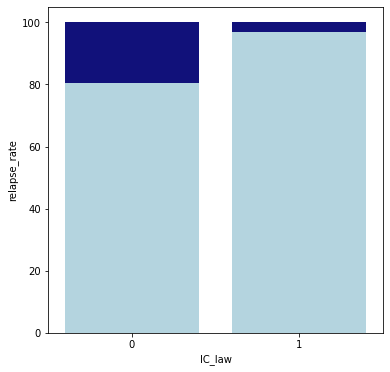

In [14]:
## Index casese of alcohol use at intake
alc_cases = teds_imp_laws.alc_cases == 1

plt.figure(figsize=(6, 6))
plot_data = teds_imp_laws.loc[
    alc_cases,['IC_law','alc_cases','alc_relapse']
].groupby(['IC_law']).sum().reset_index().assign(
    relapse_rate = lambda x: 100*(x['alc_relapse'] / x['alc_cases']),
    total = [100, 100]
)
print(plot_data)
total_bars = sns.barplot(
    x="IC_law",  
    y="total",
    data=plot_data, 
    color='darkblue'
)

rate_bars = sns.barplot(
    x="IC_law",  
    y="relapse_rate",
    data=plot_data, 
    color='lightblue'
)
plt.show()




   IC_law  hrn_cases  hrn_relapse  relapse_rate  total
0       0     130957        98536     75.243019    100
1       1     210474       201793     95.875500    100


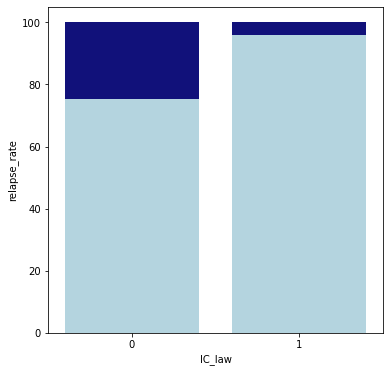

In [15]:
## Index casese of alcohol use at intake
hrn_cases = teds_imp_laws.hrn_cases == 1
plt.figure(figsize=(6, 6))
plot_data = teds_imp_laws.loc[
    hrn_cases,['IC_law','hrn_cases','hrn_relapse']
].groupby(['IC_law']).sum().reset_index().assign(
    relapse_rate = lambda x: 100*(x['hrn_relapse'] / x['hrn_cases']),
    total = [100, 100]
)
print(plot_data)
total_bars = sns.barplot(
    x="IC_law",  
    y="total",
    data=plot_data, 
    color='darkblue'
)

rate_bars = sns.barplot(
    x="IC_law",  
    y="relapse_rate",
    data=plot_data, 
    color='lightblue'
)
plt.show()




   IC_law  met_cases  met_relapse  relapse_rate  total
0       0      22936        21937     95.644402    100
1       1     121984       114550     93.905758    100


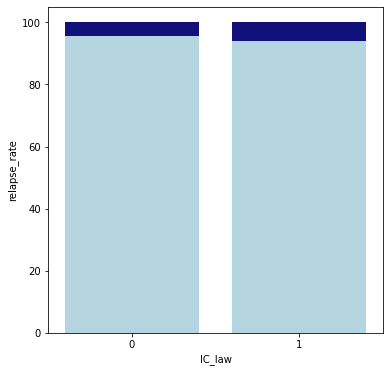

In [16]:
## Index casese of alcohol use at intake
met_cases = teds_imp_laws.met_cases == 1

plt.figure(figsize=(6, 6))
plot_data = teds_imp_laws.loc[
    met_cases,['IC_law','met_cases','met_relapse']
].groupby(['IC_law']).sum().reset_index().assign(
    relapse_rate = lambda x: 100*(x['met_relapse'] / x['met_cases']),
    total = [100, 100]
)
print(plot_data)
total_bars = sns.barplot(
    x="IC_law",  
    y="total",
    data=plot_data, 
    color='darkblue'
)

rate_bars = sns.barplot(
    x="IC_law",  
    y="relapse_rate",
    data=plot_data, 
    color='lightblue'
)
plt.show()




In [17]:
## Calculate Refferal Rates by Category
totals=teds_imp_laws.loc[:,['IC_law', 'pre_2016', 'PSOURCE']].assign(
    ref_individual = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 1, axis=1),
    ref_care = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 2, axis=1),
    ref_health = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 3, axis=1),
    ref_school = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 4, axis=1),
    ref_employer = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 5, axis=1),
    ref_community = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 6, axis=1),
    ref_adjudicated = lambda x: x.loc[:,['PSOURCE']].apply(lambda x: x['PSOURCE'] == 7, axis=1)
).groupby(['IC_law', 'pre_2016']).sum().drop(columns=['PSOURCE'])

totals.div(totals.sum(axis=1), axis=0)



ref_individual  ref_care  ref_health  ref_school  \
IC_law pre_2016                                                     
0      False           0.360253  0.129849    0.064100    0.001969   
1      False           0.408542  0.106751    0.061510    0.005051   
       True            0.434139  0.078388    0.094012    0.004569   

                 ref_employer  ref_community  ref_adjudicated  
IC_law pre_2016                                                
0      False         0.006089       0.122696         0.315043  
1      False         0.001964       0.110049         0.306133  
       True          0.002228       0.094746         0.291918

In [ ]:
## Calculate the proportion of cases in IC_Law states for each level of
## length of stay
totals=teds_imp_laws.loc[:,['IC_law', 'pre_2016', 'LOS']].groupby(['LOS']).sum()
totals.div(teds_imp_laws.loc[:,['IC_law', 'pre_2016', 'LOS']].groupby(['LOS']).count(), axis=1)

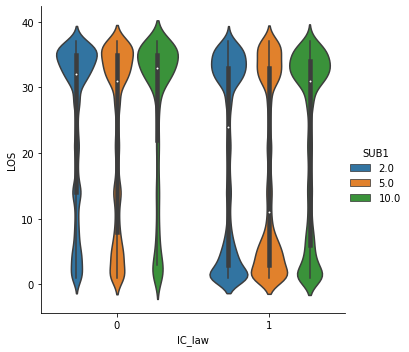

In [19]:
## Evaluate median Length of stay by IC_Law status
#teds_imp_laws.iloc[:,['IC_law']]
teds_imp_laws['IC_law']=teds_imp_laws['IC_law'].astype(
    pd.CategoricalDtype(
        categories =[0, 1], ordered=False)
)

teds_imp_laws['LOS']=teds_imp_laws['LOS'].astype('int')
bad_drugs=teds_imp_laws.SUB1.isin([2,5,10])
sns.catplot(
    x="IC_law", y="LOS", hue="SUB1", 
    kind="violin", data=teds_imp_laws.loc[bad_drugs,:]
)

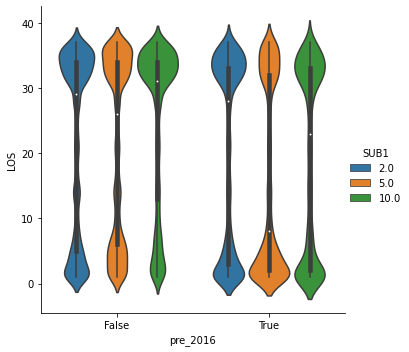

In [7]:

teds_imp_laws['LOS']=teds_imp_laws['LOS'].astype('int')
bad_drugs=teds_imp_laws.SUB1.isin([2,5,10])
sns.catplot(
    x="pre_2016", y="LOS", hue="SUB1", 
    kind="violin", data=teds_imp_laws.loc[bad_drugs,:]
)